100%|██████████| 9.46M/9.46M [00:00<00:00, 125MB/s]


Episode 0, Loss: 1.6094, Acc: 0.1600
Episode 200, Loss: 1.2326, Acc: 0.7600
Episode 400, Loss: 1.2735, Acc: 0.6000
Episode 600, Loss: 1.1327, Acc: 0.8400
Episode 800, Loss: 0.9816, Acc: 0.9200
Episode 1000, Loss: 0.9378, Acc: 1.0000
Episode 1200, Loss: 0.9431, Acc: 1.0000
Episode 1400, Loss: 0.9480, Acc: 1.0000
Episode 1600, Loss: 1.1984, Acc: 0.7600
Episode 1800, Loss: 1.2034, Acc: 0.7200
Test Accuracy: 80.24%


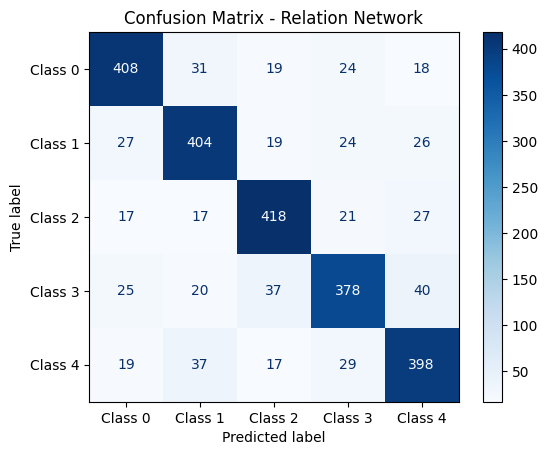

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import Omniglot
from torchvision import transforms
import random
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

# ✅ Relation Module
class RelationModule(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size * 2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ✅ Relation Network model
class RelationNet(nn.Module):
    def __init__(self, encoder, relation_module):
        super().__init__()
        self.encoder = encoder
        self.relation = relation_module

    def forward(self, support_x, support_y, query_x, n_way):
        support_embed = self.encoder(support_x)  # [S, d]
        query_embed = self.encoder(query_x)      # [Q, d]

        scores = []
        for q in query_embed:
            rel_scores = []
            for s in support_embed:
                rel_scores.append(self.relation(q.unsqueeze(0), s.unsqueeze(0)))  # [1, 1]
            rel_scores = torch.cat(rel_scores, dim=0).view(1, -1)
            scores.append(rel_scores)

        scores = torch.cat(scores, dim=0)  # [Q, S]
        one_hot = F.one_hot(support_y, num_classes=n_way).float()
        preds = torch.matmul(F.softmax(scores, dim=1), one_hot)
        return preds

# ✅ Load dữ liệu Omniglot
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1.0 - x)
])
dataset = Omniglot(root='./data', background=True, download=True, transform=transform)

data_by_class = defaultdict(list)
for img, label in dataset:
    data_by_class[label].append(img)

def create_episode(n_way=5, k_shot=5, q_query=5):
    selected_classes = random.sample(list(data_by_class.keys()), n_way)
    support, query = [], []
    for i, cls in enumerate(selected_classes):
        samples = random.sample(data_by_class[cls], k_shot + q_query)
        support += [(img, i) for img in samples[:k_shot]]
        query += [(img, i) for img in samples[k_shot:]]
    return support, query

# ✅ Huấn luyện
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
relation_module = RelationModule(input_size=64).to(device)
model = RelationNet(encoder, relation_module).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for episode in range(2000):
    support, query = create_episode()
    support_x, support_y = zip(*support)
    query_x, query_y = zip(*query)

    support_x = torch.stack(support_x).to(device)
    support_y = torch.tensor(support_y).to(device)
    query_x = torch.stack(query_x).to(device)
    query_y = torch.tensor(query_y).to(device)

    preds = model(support_x, support_y, query_x, n_way=5)
    loss = F.cross_entropy(preds, query_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if episode % 200 == 0:
        acc = (preds.argmax(1) == query_y).float().mean().item()
        print(f"Episode {episode}, Loss: {loss.item():.4f}, Acc: {acc:.4f}")

# ✅ Đánh giá
model.eval()
all_preds, all_labels = [], []
for _ in range(100):
    support, query = create_episode()
    support_x, support_y = zip(*support)
    query_x, query_y = zip(*query)

    support_x = torch.stack(support_x).to(device)
    support_y = torch.tensor(support_y).to(device)
    query_x = torch.stack(query_x).to(device)
    query_y = torch.tensor(query_y).to(device)

    preds = model(support_x, support_y, query_x, n_way=5)
    all_preds.extend(preds.argmax(1).cpu().numpy())
    all_labels.extend(query_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc*100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(5)])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Relation Network")
plt.show()
